In [18]:
import pandas as pd 
import sqlite3
import scipy.stats as sps
import matplotlib.pyplot as plt
from dataclasses import dataclass
import numpy as np
import requests as r

In [53]:
plt.style.use('ggplot')

In [34]:
map_hero_names = pd.read_json('../ETL/dbs/hero_names.json',typ='series').to_dict()
with sqlite3.Connection('../ETL/dbs/dotaIIbase.db') as c:
    tmp_matric = pd.read_sql('select * from INTEL_matrix_table',con=c)
hero_matrix = tmp_matric.apply(lambda x: x.map(map_hero_names) if x.name.endswith('team') else x)\
                        .pivot_table('value','win_team',['stats_type','lose_team'],aggfunc='sum')

In [110]:
@dataclass
class TeamPick:
    '''
    Класс характеризующий набор героев команды  \n
    Подсчитывает взвешенную баесовский loglike победы
    '''
    hero_matrix:pd.DataFrame
    def __post_init__(self):
        if not isinstance(self.hero_matrix,pd.DataFrame):
            raise ValueError('нужен dataframe')
        self.hero_matrix = self.hero_matrix.sum()
        self.value_space = np.array([np.linspace(.5,.99)]*self.hero_matrix['sum'].shape[0]).T
        self.defeats = self.hero_matrix['count'] - self.hero_matrix['sum']
        self.wins = self.hero_matrix['sum']
        
    def get_scores(self):
        """
        LogLike оценка победы команды  \n
        Чем выше число, тем лучше для выбранной команды  \n

        Можно использовать наоборот. \n
        Выбрав чужую команду смотреть наименьшее значение
        
        """
        hero_distr = sps.beta(self.wins+1,self.defeats+1)
        log_like = np.log1p(hero_distr.sf(self.value_space)).sum(axis=0) / hero_distr.std()


        return pd.Series(log_like,self.wins.index)
        
    def plot_top(self,n=10,**kwargs):
        """
        plot top_n
        """
        scores = self.get_scores().sort_values()
        data = pd.concat([scores.iloc[:n],
                            scores.iloc[-n:]]
                        ).rename('win log like')\
                            .to_frame()\
                                .apply(lambda x: (x-x.mean()) / x.std())
        return data.plot.bar(title=self.hero_matrix.name,**kwargs)

In [111]:
pugna = TeamPick(hero_matrix.loc[['pugna']])
antimage = TeamPick(hero_matrix.loc[['antimage']])

In [112]:
team_a_picks = ['kunkka','ogre_magi','troll_warlord','skywrath_mage','pangolier']
team_b_picks = ['death_prophet','bloodseeker','sand_king','bane','grimstroke']

In [113]:
team_a = TeamPick(hero_matrix.loc[team_a_picks])
team_b = TeamPick(hero_matrix.loc[team_b_picks])

In [114]:
team_a.get_scores().loc[team_b_picks]

lose_team
death_prophet     71.017998
bloodseeker        4.839381
sand_king        151.210129
bane             160.169721
grimstroke       167.886966
dtype: float64

<AxesSubplot:xlabel='lose_team'>

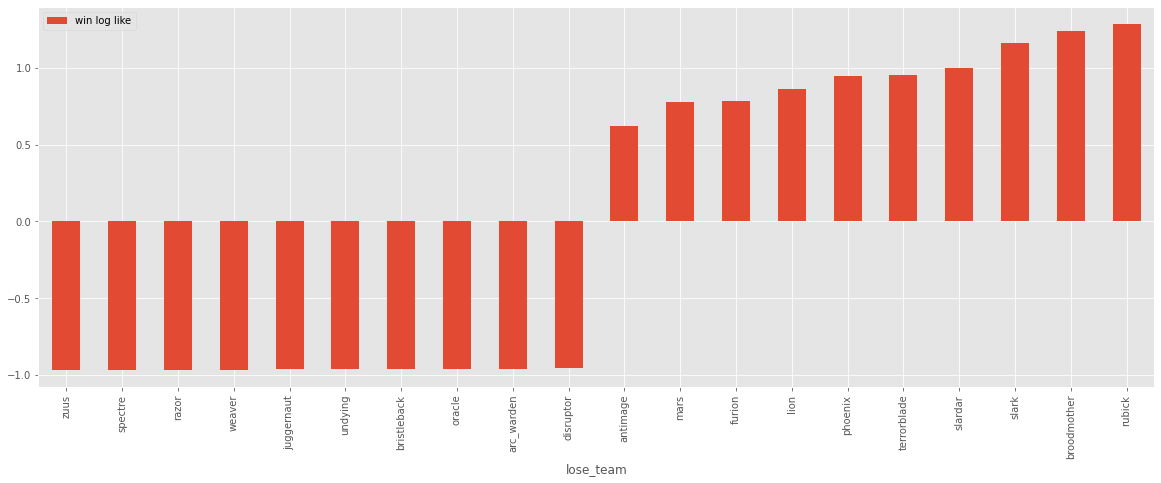

In [115]:
team_b.plot_top(figsize=(20,7))